In [2]:
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV

In [3]:
!ls data

sat.trn sat.tst


In [4]:
train, test = np.loadtxt('data/sat.trn'), np.loadtxt('data/sat.tst')

In [5]:
train

array([[ 92., 115., 120., ..., 113.,  87.,   3.],
       [ 84., 102., 106., ..., 104.,  79.,   3.],
       [ 84., 102., 102., ..., 104.,  79.,   3.],
       ...,
       [ 68.,  75., 108., ..., 104.,  85.,   4.],
       [ 71.,  87., 108., ..., 104.,  85.,   4.],
       [ 71.,  91., 100., ..., 100.,  81.,   4.]])

In [6]:
test

array([[ 80., 102., 102., ..., 113.,  87.,   3.],
       [ 76., 102., 102., ..., 104.,  83.,   3.],
       [ 80.,  98., 106., ...,  96.,  75.,   4.],
       ...,
       [ 56.,  68.,  91., ...,  92.,  74.,   5.],
       [ 56.,  68.,  87., ...,  92.,  70.,   5.],
       [ 60.,  71.,  91., ..., 108.,  92.,   5.]])

In [7]:
print(train.shape, test.shape)

(4435, 37) (2000, 37)


In [8]:
# Separate labels into different vectors
y_train, y_test = train[:,-1], test[:,-1]

In [9]:
y_train, y_test

(array([3., 3., 3., ..., 4., 4., 4.]), array([3., 3., 4., ..., 5., 5., 5.]))

In [10]:
print(len(y_train), len(y_test))

4435 2000


In [11]:
# Separate 3x3x4 pixel neighborhood samples into train and test feature samples
X_train, X_test = train[:,:-1], test[:,:-1]

In [12]:
X_train

array([[ 92., 115., 120., ..., 107., 113.,  87.],
       [ 84., 102., 106., ...,  99., 104.,  79.],
       [ 84., 102., 102., ...,  99., 104.,  79.],
       ...,
       [ 68.,  75., 108., ..., 100., 104.,  85.],
       [ 71.,  87., 108., ...,  91., 104.,  85.],
       [ 71.,  91., 100., ...,  91., 100.,  81.]])

## Exploratory Data Analysis

In [13]:
# Determine class count for each label in training set
def class_counts(y):
    labels, labels_inverse, label_counts = np.unique(y, return_inverse=True, return_counts=True)
    return labels, labels_inverse, label_counts

In [14]:
labels, labels_inverse, label_counts = class_counts(y_train)

<ipython-input-16-c8d4ec1e2b31>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','1 - red soil', '2 - cotton crop', '3 - grey soil', '4 - damp grey soil', '5 - soil w/veg.', '6 - mixture', '7 - very damp grey soil'], rotation=45);


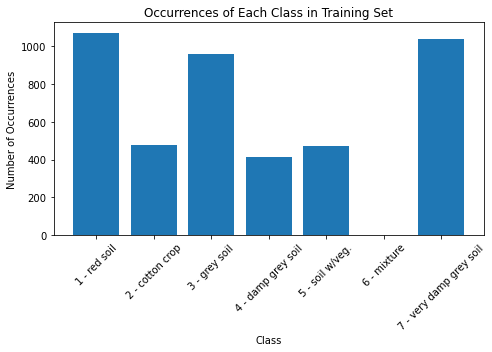

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(labels, label_counts)
ax.set_xlabel('Class')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Occurrences of Each Class in Training Set')
ax.set_xticklabels(['','1 - red soil', '2 - cotton crop', '3 - grey soil', '4 - damp grey soil', '5 - soil w/veg.', '6 - mixture', '7 - very damp grey soil'], rotation=45);

plt.tight_layout()
plt.savefig('imgs/train_class_count.png')

In [17]:
# Calculate and plot mean spectral signature for each class
means = []
for idx,label in enumerate(labels):
    means.append(np.mean(X_train[labels_inverse==idx,16:20], axis=0))
# 

In [18]:
means

[array([ 62.8255597 ,  95.29384328, 108.12313433,  88.60074627]),
 array([ 48.83924843,  39.91440501, 113.88935282, 118.31106472]),
 array([ 87.47866805, 105.49843913, 110.5962539 ,  87.45681582]),
 array([77.40963855, 90.94457831, 95.61445783, 75.35421687]),
 array([59.5893617 , 62.26595745, 83.02340426, 69.95319149]),
 array([69.01252408, 77.42196532, 81.59248555, 64.12524085])]

In [19]:
# Calculate cosine similarity of mean vectors

In [20]:
# 3D Histogram of Pixel Neighborhood?

In [21]:
# Plot Average intensity for neighborhood across each band

In [22]:
# Scatter plot of mean vectors for each class

## Sanity Check

In [23]:
X_train[0,:]

array([ 92., 115., 120.,  94.,  84., 102., 106.,  79.,  84., 102., 102.,
        83., 101., 126., 133., 103.,  92., 112., 118.,  85.,  84., 103.,
       104.,  81., 102., 126., 134., 104.,  88., 121., 128., 100.,  84.,
       107., 113.,  87.])

In [24]:
X_train[0,16:20]

array([ 92., 112., 118.,  85.])

In [25]:
train[0,:]

array([ 92., 115., 120.,  94.,  84., 102., 106.,  79.,  84., 102., 102.,
        83., 101., 126., 133., 103.,  92., 112., 118.,  85.,  84., 103.,
       104.,  81., 102., 126., 134., 104.,  88., 121., 128., 100.,  84.,
       107., 113.,  87.,   3.])

## Baseline Model

In [26]:
# Classify each sample by closest distance to mean vector
mean_dict = {label: means[i] for i,label in enumerate(labels)} # Create dictionary of mean spectral vector per class label

In [27]:
mean_dict 

{1.0: array([ 62.8255597 ,  95.29384328, 108.12313433,  88.60074627]),
 2.0: array([ 48.83924843,  39.91440501, 113.88935282, 118.31106472]),
 3.0: array([ 87.47866805, 105.49843913, 110.5962539 ,  87.45681582]),
 4.0: array([77.40963855, 90.94457831, 95.61445783, 75.35421687]),
 5.0: array([59.5893617 , 62.26595745, 83.02340426, 69.95319149]),
 7.0: array([69.01252408, 77.42196532, 81.59248555, 64.12524085])}

In [28]:
def euclidean_distance(a,b):
    return np.sqrt(sum((a-b)**2))

In [29]:
euclidean_distance(train[-1,16:20], mean_dict[3.0])

24.776905414321906

In [30]:
def min_distance_classifier(X, mean_dict,labels):
    predicts = []
    label_dict = {num:label for num,label in zip(np.arange(len(labels)), labels)}
    for sample in X[:,16:20]:
        mean_index = np.argmin([euclidean_distance(sample, mean_vector) for mean_vector in mean_dict.values()])
        predicts.append(label_dict[mean_index])
    return np.array(predicts)

In [31]:
y_predict = min_distance_classifier(X_train, mean_dict, labels)

In [32]:
y_predict

array([3., 3., 4., ..., 4., 4., 4.])

In [33]:
np.count_nonzero(y_predict == y_train)/len(X_train)

0.7641488162344983

In [34]:
y_test_predict = min_distance_classifier(X_test, mean_dict, labels)

In [35]:
np.count_nonzero(y_test_predict == y_test)/len(X_test)

0.7685

In [36]:
y_test_predict

array([3., 3., 4., ..., 5., 7., 1.])

In [37]:
y_test

array([3., 3., 4., ..., 5., 5., 5.])

## Neural Network

In [38]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

In [39]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

enc.fit(y_train.reshape(-1,1))

y_trn_1hot = enc.transform(y_train.reshape(-1,1)).toarray()


In [40]:
# Scale the training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_trn_scaled = scaler.transform(X_train)


In [41]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
hidden_units = 100
n_classes = 6

In [71]:
def create_model(X, n_classes, opt='Adam', hidden_units=100, drop_out=0, activ='softsign'):
    np.random.seed(42)

    n_samples, n_feats = X.shape

    model = Sequential() # sequence of layers

    hidden_layer = Dense(units=hidden_units,
                    input_dim=n_feats,
                    kernel_initializer='constant',
                    activation=activ)

    hidden_layer_2 = Dense(units=hidden_units,
                    kernel_initializer='constant',
                    activation=activ)

    outputlayer = Dense(units=n_classes,
                    input_dim=hidden_units,
                    kernel_initializer='uniform',
                    activation='softmax')

    model.add(hidden_layer)
    model.add(Dropout(drop_out))
    model.add(hidden_layer_2)
    model.add(Dropout(drop_out))
    model.add(hidden_layer_2)
    model.add(Dropout(drop_out))
    model.add(outputlayer)

    model.compile(loss='categorical_crossentropy', 
                  optimizer=opt, metrics=["accuracy"])
    return model

In [59]:
model = create_model(X_trn_scaled, n_classes, opt)

In [60]:
history = model.fit(X_trn_scaled, y_trn_1hot, epochs=350, batch_size=50, verbose=1, validation_split=0)


Epoch 1/350
89/89 [==============================] - 0s 945us/step - loss: 1.4415 - accuracy: 0.3448
Epoch 2/350
89/89 [==============================] - 0s 978us/step - loss: 0.9531 - accuracy: 0.5831
Epoch 3/350
89/89 [==============================] - 0s 960us/step - loss: 0.8357 - accuracy: 0.6974
Epoch 4/350
89/89 [==============================] - 0s 1ms/step - loss: 0.6464 - accuracy: 0.7921
Epoch 5/350
89/89 [==============================] - 0s 1ms/step - loss: 0.5055 - accuracy: 0.8201
Epoch 6/350
89/89 [==============================] - 0s 1ms/step - loss: 0.4402 - accuracy: 0.8372
Epoch 7/350
89/89 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.8397
Epoch 8/350
89/89 [==============================] - 0s 1ms/step - loss: 0.4069 - accuracy: 0.8489
Epoch 9/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3944 - accuracy: 0.8474
Epoch 10/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.8537
Epo

89/89 [==============================] - 0s 905us/step - loss: 0.2924 - accuracy: 0.8823
Epoch 82/350
89/89 [==============================] - 0s 943us/step - loss: 0.2886 - accuracy: 0.8816
Epoch 83/350
89/89 [==============================] - 0s 923us/step - loss: 0.2882 - accuracy: 0.8864
Epoch 84/350
89/89 [==============================] - 0s 944us/step - loss: 0.2877 - accuracy: 0.8875
Epoch 85/350
89/89 [==============================] - 0s 767us/step - loss: 0.2895 - accuracy: 0.8868
Epoch 86/350
89/89 [==============================] - 0s 945us/step - loss: 0.2877 - accuracy: 0.8850
Epoch 87/350
89/89 [==============================] - 0s 933us/step - loss: 0.2927 - accuracy: 0.8825
Epoch 88/350
89/89 [==============================] - 0s 907us/step - loss: 0.2870 - accuracy: 0.8843
Epoch 89/350
89/89 [==============================] - 0s 939us/step - loss: 0.2943 - accuracy: 0.8825
Epoch 90/350
89/89 [==============================] - 0s 983us/step - loss: 0.2899 - accuracy: 

89/89 [==============================] - 0s 974us/step - loss: 0.2483 - accuracy: 0.9012
Epoch 162/350
89/89 [==============================] - 0s 904us/step - loss: 0.2492 - accuracy: 0.9008
Epoch 163/350
89/89 [==============================] - 0s 941us/step - loss: 0.2512 - accuracy: 0.9019
Epoch 164/350
89/89 [==============================] - 0s 951us/step - loss: 0.2442 - accuracy: 0.9028
Epoch 165/350
89/89 [==============================] - 0s 936us/step - loss: 0.2414 - accuracy: 0.9012
Epoch 166/350
89/89 [==============================] - 0s 950us/step - loss: 0.2413 - accuracy: 0.9062
Epoch 167/350
89/89 [==============================] - 0s 899us/step - loss: 0.2449 - accuracy: 0.9021
Epoch 168/350
89/89 [==============================] - 0s 972us/step - loss: 0.2399 - accuracy: 0.9019
Epoch 169/350
89/89 [==============================] - 0s 930us/step - loss: 0.2417 - accuracy: 0.9015
Epoch 170/350
89/89 [==============================] - 0s 976us/step - loss: 0.2358 - a

89/89 [==============================] - 0s 844us/step - loss: 0.1998 - accuracy: 0.9215
Epoch 241/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.9200
Epoch 242/350
89/89 [==============================] - 0s 985us/step - loss: 0.2021 - accuracy: 0.9166
Epoch 243/350
89/89 [==============================] - 0s 926us/step - loss: 0.2035 - accuracy: 0.9197
Epoch 244/350
89/89 [==============================] - 0s 924us/step - loss: 0.1989 - accuracy: 0.9224
Epoch 245/350
89/89 [==============================] - 0s 894us/step - loss: 0.2015 - accuracy: 0.9227
Epoch 246/350
89/89 [==============================] - 0s 944us/step - loss: 0.2011 - accuracy: 0.9202
Epoch 247/350
89/89 [==============================] - 0s 944us/step - loss: 0.1981 - accuracy: 0.9220
Epoch 248/350
89/89 [==============================] - 0s 976us/step - loss: 0.1999 - accuracy: 0.9188
Epoch 249/350
89/89 [==============================] - 0s 1ms/step - loss: 0.1995 - accur

89/89 [==============================] - 0s 836us/step - loss: 0.1743 - accuracy: 0.9317
Epoch 320/350
89/89 [==============================] - 0s 929us/step - loss: 0.1727 - accuracy: 0.9324
Epoch 321/350
89/89 [==============================] - 0s 958us/step - loss: 0.1729 - accuracy: 0.9299
Epoch 322/350
89/89 [==============================] - 0s 938us/step - loss: 0.1821 - accuracy: 0.9290
Epoch 323/350
89/89 [==============================] - 0s 924us/step - loss: 0.1790 - accuracy: 0.9299
Epoch 324/350
89/89 [==============================] - 0s 948us/step - loss: 0.1710 - accuracy: 0.9317
Epoch 325/350
89/89 [==============================] - 0s 942us/step - loss: 0.1670 - accuracy: 0.9366
Epoch 326/350
89/89 [==============================] - 0s 845us/step - loss: 0.1716 - accuracy: 0.9326
Epoch 327/350
89/89 [==============================] - 0s 950us/step - loss: 0.1705 - accuracy: 0.9330
Epoch 328/350
89/89 [==============================] - 0s 867us/step - loss: 0.1693 - a

In [45]:
history.history

{'loss': [1.6951053142547607,
  1.3588849306106567,
  1.2700804471969604,
  1.059291958808899,
  0.8675603866577148,
  0.7963805198669434,
  0.6951545476913452,
  0.6210228800773621,
  0.5538510084152222,
  0.49651074409484863,
  0.46549513936042786,
  0.4305870532989502,
  0.4167126715183258,
  0.4001719355583191,
  0.3997628092765808,
  0.383284330368042,
  0.37782421708106995,
  0.3907758295536041,
  0.3788404166698456,
  0.3682679831981659,
  0.36314570903778076,
  0.3595249056816101,
  0.35912224650382996,
  0.35271915793418884,
  0.3526783883571625,
  0.3461886942386627,
  0.3477564752101898,
  0.3431975543498993,
  0.35237157344818115,
  0.34340760111808777,
  0.33696186542510986,
  0.33773529529571533,
  0.33733081817626953,
  0.3376091420650482,
  0.34914812445640564,
  0.3354492485523224,
  0.3315467834472656,
  0.3278590738773346,
  0.32779914140701294,
  0.3275933563709259,
  0.3240963816642761,
  0.33801570534706116,
  0.3314921259880066,
  0.32358086109161377,
  0.3241511

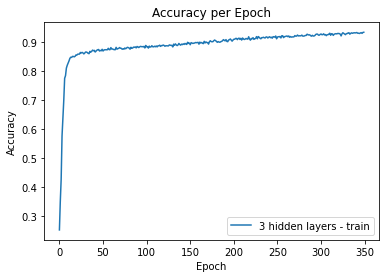

In [46]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['accuracy'], label = '3 hidden layers - train')
#ax.plot(history.epoch, history.history['val_accuracy'], label = '3 hidden layers - val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per Epoch')
ax.legend()

In [61]:
model.evaluate(scaler.transform(X_test), enc.transform(y_test.reshape(-1,1)).toarray())  # Calculate performance metrics on unseen test data

63/63 [==============================] - 0s 690us/step - loss: 0.2550 - accuracy: 0.8975


[0.2550421357154846, 0.8974999785423279]

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
yhat_trn = clf.predict(X_train)
print(accuracy_score(y_train, yhat_trn))
yhat = clf.predict(X_test)
print(accuracy_score(y_test, yhat))

1.0
0.849


In [53]:
#print(y_train.shape, y_predict.shape)
print(f'Baseline Model Accuracy: {accuracy_score(y_train,y_predict)}') # Baseline model accuracy

Baseline Model Accuracy: 0.7641488162344983


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_trn_rf = clf.predict(X_train)
print(f'Train Accuracy: {accuracy_score(y_train, y_trn_rf)}')
y_rf = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_rf)}')

Train Accuracy: 0.9713641488162345
Test Accuracy: 0.903


## Grid Search

In [72]:
modelo = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, X=X_trn_scaled, n_classes=6, opt=opt)

In [73]:
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

In [74]:
# Set grid search parameters
param_grid = dict(epochs=[350, 400], batch_size=[40], drop_out = [0,0.05,0.1], activ=activation)
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_trn_scaled, y_trn_1hot)

Epoch 1/350
111/111 [==============================] - 0s 1ms/step - loss: 1.7138 - accuracy: 0.2379
Epoch 2/350
111/111 [==============================] - 0s 1ms/step - loss: 1.4908 - accuracy: 0.4187
Epoch 3/350
111/111 [==============================] - 0s 1ms/step - loss: 1.1525 - accuracy: 0.5707
Epoch 4/350
111/111 [==============================] - 0s 1ms/step - loss: 1.0235 - accuracy: 0.5790
Epoch 5/350
111/111 [==============================] - 0s 1ms/step - loss: 0.9761 - accuracy: 0.5766
Epoch 6/350
111/111 [==============================] - 0s 1ms/step - loss: 0.9539 - accuracy: 0.5862
Epoch 7/350
111/111 [==============================] - 0s 1ms/step - loss: 0.9397 - accuracy: 0.5944
Epoch 8/350
111/111 [==============================] - 0s 997us/step - loss: 0.9380 - accuracy: 0.6005
Epoch 9/350
111/111 [==============================] - 0s 1ms/step - loss: 0.9288 - accuracy: 0.6072
Epoch 10/350
111/111 [==============================] - 0s 1ms/step - loss: 0.9284 - accu

111/111 [==============================] - 0s 1ms/step - loss: 0.4282 - accuracy: 0.8356
Epoch 82/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4276 - accuracy: 0.8359
Epoch 83/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4343 - accuracy: 0.8316
Epoch 84/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4244 - accuracy: 0.8365
Epoch 85/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4258 - accuracy: 0.8374
Epoch 86/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4218 - accuracy: 0.8372
Epoch 87/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.8331
Epoch 88/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4161 - accuracy: 0.8377
Epoch 89/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.8386
Epoch 90/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4202 - accuracy: 

111/111 [==============================] - 0s 1ms/step - loss: 0.3701 - accuracy: 0.8530
Epoch 161/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.8593
Epoch 162/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3586 - accuracy: 0.8591
Epoch 163/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3688 - accuracy: 0.8543
Epoch 164/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3695 - accuracy: 0.8570
Epoch 165/350
111/111 [==============================] - 0s 940us/step - loss: 0.3598 - accuracy: 0.8541
Epoch 166/350
111/111 [==============================] - 0s 963us/step - loss: 0.3630 - accuracy: 0.8552
Epoch 167/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3559 - accuracy: 0.8595
Epoch 168/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3612 - accuracy: 0.8604
Epoch 169/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3628

111/111 [==============================] - 0s 1ms/step - loss: 0.3375 - accuracy: 0.8647
Epoch 240/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3384 - accuracy: 0.8670
Epoch 241/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3384 - accuracy: 0.8672
Epoch 242/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3424 - accuracy: 0.8652
Epoch 243/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3433 - accuracy: 0.8647
Epoch 244/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3365 - accuracy: 0.8656
Epoch 245/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3465 - accuracy: 0.8620
Epoch 246/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3395 - accuracy: 0.8674
Epoch 247/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3409 - accuracy: 0.8649
Epoch 248/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3363 - a

111/111 [==============================] - 0s 1ms/step - loss: 0.3238 - accuracy: 0.8742
Epoch 319/350
111/111 [==============================] - 0s 992us/step - loss: 0.3186 - accuracy: 0.8685
Epoch 320/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3190 - accuracy: 0.8701
Epoch 321/350
111/111 [==============================] - 0s 991us/step - loss: 0.3150 - accuracy: 0.8744
Epoch 322/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3159 - accuracy: 0.8692
Epoch 323/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3167 - accuracy: 0.8697
Epoch 324/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3211 - accuracy: 0.8724
Epoch 325/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3182 - accuracy: 0.8724
Epoch 326/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3187 - accuracy: 0.8764
Epoch 327/350
111/111 [==============================] - 0s 922us/step - loss: 0.31

In [75]:
grid_result.best_params_

{'activ': 'sigmoid', 'batch_size': 40, 'drop_out': 0.1, 'epochs': 350}

In [76]:
grid_result.best_score_

0.8444193959236145

In [77]:
np.mean(grid_result.best_estimator_.model.history.history['accuracy']), max(grid_result.best_estimator_.model.history.history['accuracy'])

(0.8403060079472405, 0.8780157566070557)

In [387]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.857961 using {'batch_size': 40, 'epochs': 350}


In [79]:
grid_result.best_estimator_.model.evaluate(scaler.transform(X_test), enc.transform(y_test.reshape(-1,1)).toarray())

63/63 [==============================] - 0s 976us/step - loss: 0.3237 - accuracy: 0.8615


[0.3237186372280121, 0.8615000247955322]

In [362]:
grid_result.cv_results_

{'mean_fit_time': array([56.24861321, 64.36048489, 60.57246938, 42.5437993 , 52.98535657,
        60.41846099, 35.27427649, 40.8893455 , 67.4784328 ]),
 'std_fit_time': array([13.14371865, 15.42406399,  3.70558941,  0.59993382, 15.29722387,
        18.54836781,  6.66976495,  2.03972572, 19.48062645]),
 'mean_score_time': array([0.39819913, 0.23898735, 0.3438087 , 0.40139656, 0.32555408,
        0.27125497, 0.34570761, 0.44886274, 0.26565518]),
 'std_score_time': array([0.13411262, 0.07360778, 0.12108703, 0.11008736, 0.07049034,
        0.10319552, 0.09303471, 0.11655359, 0.09310975]),
 'param_batch_size': masked_array(data=[40, 40, 40, 50, 50, 50, 60, 60, 60],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[300, 350, 400, 300, 350, 400, 300, 350, 400],
              mask=[False, False, False, False, False, False, False, False,
                 